In [1]:
import numpy as np
import pylab as plt

from id01lib.io.h5utils import *
from id01lib.xrd.qspace.bliss import get_qspace_vals

# Functions

In [2]:
def compute_powder_diffraction_array(h5f, scan_no,
                                     nb_bin=200,
                                     flatfield=None,
                                     detector_mask=None,
                                     plot=False):
    '''
    params
    :h5f: dataset h5 filename 
    :scan_no: scan number
    :n_bin: number of points in the returned array I of 1D powder diffraction. 
            nb_bin too large : lots of noise but high resolution
            nb_bin too small : no noise but low resolution
            try to find the best compromise for your data
    :flatfield: detector flatfield. Very useful for low intensity data
    :detector_mask: 2D mask of the same shape as the detector. 
    
    return 
    :q_norm: 1D array of wavevector norm
    :two_theta: two theta corresponding to q_norm
    :I: 1D powder diffraction intensity
    '''    
    
    # open the idetector mages
    scan = openScan(h5f, scan_no)
    data = scan.getImages()
    data = np.array(data, dtype='float64')
    
    if plot:
        fig,ax = plt.subplots(1,2, figsize=(8,4))
        ax[0].matshow(np.log(np.nanmean(data,axis=0)))
        ax[0].set_title('sum of the scan images', fontsize=15)
        
    # flatfield and mask corrections
    for n in range(len(data)):
        if flatfield is not None:
            data[n] = data[n]*flatfield
        if mask is not None:
            data[n, mask==0] = np.nan
            
    if plot:
        ax[1].matshow(np.log(np.nanmean(data,axis=0)))
        ax[1].set_title('sum of the scan images after correction\n(if mask and/or flatfield is not None)', fontsize=12)
        fig.tight_layout()
        
    # Compute q values for each pixel in data
    qx, qy, qz = get_qspace_vals( filename , scan_no)
    q_norm_raw = np.sqrt(qx**2.+qy**2.+qz**2.) # q wavevector norm for each pixel in data
    
    # q norm 1d array for the 1d powder diffraction computation
    q_norm = np.linspace(np.min(q_norm_raw), np.max(q_norm_raw), nb_bin)
    dq = q_norm[1]-q_norm[0] # step of the q_norm array
    
    I = np.zeros(len(q_norm))
    
    # For each "bin" in q_norm, I average each pixel in data for which q_norm_raw is in this bin
    data_flat = data.flatten() 
    q_norm_raw_flat = q_norm_raw.flatten()
    for n in range(len(q_norm)):
        I[n] += np.nanmean(data_flat[np.abs(q_norm_raw_flat-q_norm[n])<dq])
        
    # Compute the corresponding two theta (not so important)
    with h5.File(scan.h5file, "r") as h5f:
        wavelength = h5f["{}/instrument/monochromator/WaveLength".format(scan.scan_string)][()]
    two_theta = np.rad2deg(2.*np.arcsin(wavelength*q_norm*1e10/(4.*np.pi)))
    
    if plot:
        fig = plt.figure(figsize=(8,5))
        ax1 = fig.add_subplot(111)
        ax2 = ax1.twiny()

        ax1.plot(q_norm, I, '.-')
        ax1.set_xlabel(r'|q| ($1/\AA$)', fontsize=20)
        ax1.set_ylabel('I', fontsize=20)

        ax2.plot(two_theta, I, '.-')
        ax2.set_xlabel(r'2$\theta$ (degrees)', fontsize=20)
        
        fig.tight_layout()
        
    return q_norm, two_theta, I

In [3]:
def linear_background_correction(q_norm, I,
                                 q_norm_linear_region,
                                 plot=True):
    indexes = np.logical_and(q_norm>q_norm_linear_region[0], q_norm<q_norm_linear_region[1]) 
    popt = np.polyfit(q_norm[indexes], I[indexes], deg=1)
    linear = q_norm*popt[0]
    background = popt[1]

    I_corr = (np.copy(I)-linear)/background
    
    if plot:
        fig, ax = plt.subplots(1,2, figsize=(16,5))
        ax[0].plot(q_norm, I, '.-')
        ax[0].axvline(x=q_norm_linear_region[0], linestyle='--', c='k')
        ax[0].axvline(x=q_norm_linear_region[1], linestyle='--', c='k')
        
        ax[1].plot(q_norm, I_corr, '.-')
        ax[1].set_title('linear background correction', fontsize=20)
        
        for n in range(2):
            ax[n].set_xlabel(r'|q| ($1/\AA$)', fontsize=15)
            ax[n].set_ylabel('I', fontsize=15)
    
    return I_corr

# Data treatment

In [4]:
filename = '/data/id01/inhouse/data/IHR/ihma259/id01/LMNO_s41_coincell_start/LMNO_s41_coincell_start_powder_diffr_fast_highres/LMNO_s41_coincell_start_powder_diffr_fast_highres.h5'
scanList = get_scans_title_str_hdf5(filename, '')

Available  scans in hdf5 file:
1 ... b'dscan eta -0.1 0.1 10 1'
2 ... b'ct 0.01 1'
3 ... b'dscan eta -0.1 0.1 10 1'
4 ... b'ct 0.01 1'
5 ... b'dscan eta -0.1 0.1 10 1'
6 ... b'ct 0.01 1'
7 ... b'dscan eta -0.1 0.1 10 1'
8 ... b'dscan tobz -0.1 0.1 30 0.1'
9 ... b'dscan eta -0.1 0.1 10 1'
10 ... b'ct 0.01 1'
11 ... b'dscan eta -0.1 0.1 10 1'
12 ... b'ct 0.01 1'
13 ... b'dscan eta -0.1 0.1 10 1'
14 ... b'ct 0.01 1'
15 ... b'dscan eta -0.1 0.1 10 1'
16 ... b'ct 0.01 1'
17 ... b'dscan eta -0.1 0.1 10 1'
18 ... b'ct 0.01 1'
19 ... b'dscan eta -0.1 0.1 10 1'
20 ... b'ct 0.01 1'
21 ... b'dscan eta -0.1 0.1 10 1'
22 ... b'ct 0.01 1'
23 ... b'dscan eta -0.1 0.1 10 1'
24 ... b'ct 0.01 1'
25 ... b'dscan eta -0.1 0.1 10 1'
26 ... b'ct 0.01 1'
27 ... b'dscan eta -0.1 0.1 10 1'
28 ... b'ct 0.01 1'
29 ... b'dscan eta -0.1 0.1 10 1'
30 ... b'ct 0.01 1'
31 ... b'dscan eta -0.1 0.1 10 1'
32 ... b'ct 0.01 1'
33 ... b'dscan eta -0.1 0.1 10 1'
34 ... b'ct 0.01 1'
35 ... b'dscan eta -0.1 0.1 10 1'
36 ... b'

In [5]:
scan_no = 13
scan = openScan(filename, scan_no, verbose=True)

Scan no: 13.1
detector : mpxgaas
motor : eta


Using cen_pix: x=66.624, y=54.249
Using det_dist = 1.24482 m
Using energy = 10.09963 keV
NOT correcting the central pixel for mpxy=0.0, mpxz=0.0


<ipython-input-2-b2785309434a>:41: RuntimeWarning: Mean of empty slice
  ax[1].matshow(np.log(np.nanmean(data,axis=0)))


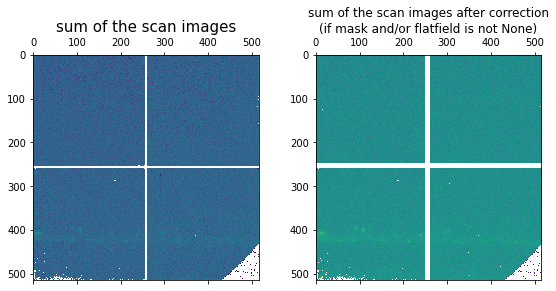

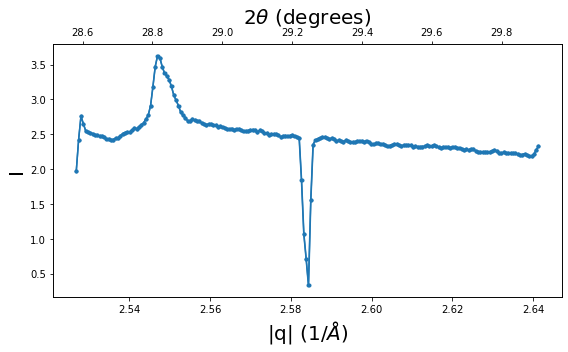

In [6]:
flatfield = np.load('/data/id01/inhouse/corentin/experiments/202205_Pt/flatfield.npz')['arr_0']

mask = np.ones((516,516))
mask[250:257] = 0
mask[:,250:257] = 0

q_norm, two_theta, I = compute_powder_diffraction_array(filename, scan_no,
                                     nb_bin=200,
                                     flatfield=flatfield,
                                     detector_mask=mask,
                                     plot=True)

# Correction of linear background (not necessary)

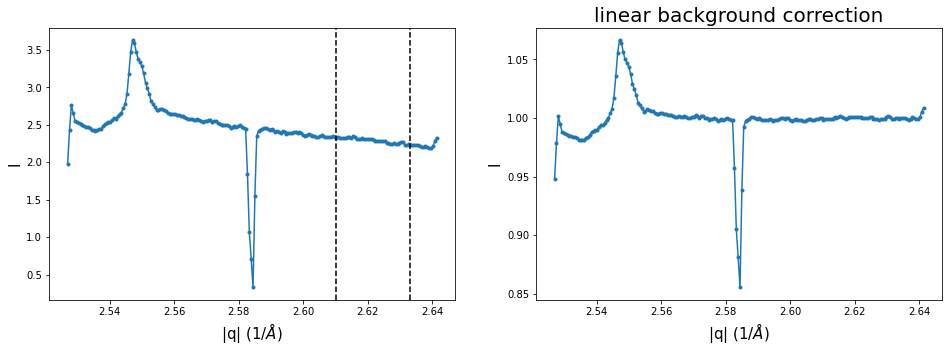

In [7]:
q_norm_linear_region = [ 2.61, 2.633]

I_corr = linear_background_correction(q_norm, I,
                                 q_norm_linear_region,
                                 plot=True)